# Paths

In [1]:
datasets_path     = 'datasets/annotated/INF692_GEST_CLAS_GE.v3i.folder/'
models_path       = 'models/'
tensorboard_path  = 'Tensorboard/YOLO-TL/'

dataset = 'INF692_GEST_CLAS_GE/' # train, test, val
# dataset = 'INF692_GEST_CLAS_MY/' # train, test, val

In [2]:
train_dir = f'{datasets_path}/train'
valid_dir = f'{datasets_path}/valid'
test_dir  = f'{datasets_path}/test'

# Libs

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms

from torchvision import datasets
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt

from datetime import datetime

from tqdm import tqdm

import copy

from ultralytics import YOLO

from torchvision import models
import torch.nn as nn

# Dataloader

In [4]:
def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()

In [5]:
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # padrão para ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [6]:
train_data = datasets.ImageFolder(root=train_dir, transform=my_transform)
valid_data = datasets.ImageFolder(root=valid_dir, transform=my_transform)
test_data  = datasets.ImageFolder(root=test_dir,  transform=my_transform)

# DataLoaders
batch_size = 8  # Verificar memória disponível

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

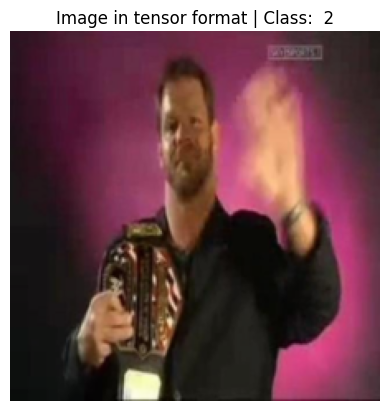

In [7]:
images, labels = next(iter(train_loader))
my_tensor_image_show(images[0], label=labels[0])

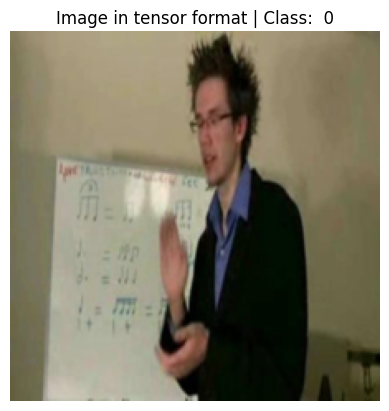

In [8]:
images, labels = next(iter(valid_loader))
my_tensor_image_show(images[0], label=labels[0])

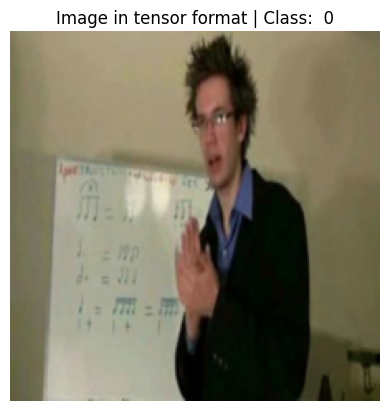

In [9]:
images, labels = next(iter(test_loader))
my_tensor_image_show(images[0], label=labels[0])

# Validation

In [10]:
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    with torch.no_grad():
        for idx, (test_x, test_label) in enumerate(data) : 
            test_x = test_x.to(device)
            test_label = test_label.to(device)
            predict_y = model( test_x ).detach()
            predict_ys = torch.max( predict_y, axis=1 )[1]
            sum = sum + test_x.size(0)
            correct = correct + torch.sum(predict_ys == test_label)
            correct = correct.cpu().item()
    
    return correct*100./sum

# Training

In [ ]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.classifier.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1



def train ( train_loader, valid_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # Loss:
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # Back propagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()

            current_step = idx + epoch * (dataset_size // batch_size)
            writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], current_step)

            
            # Accuracy:
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, valid_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
        
        torch.cuda.empty_cache()

    
    if save : 
        path = f'{models_path}MyYolo-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model   

# Run

In [12]:
# Load pre-trained ResNet18 and adapt the final layer
num_classes = len(train_data.classes)

model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Enable training only for the final layer
for param in model.fc.parameters():
    param.requires_grad = True

/home/werikson/GitHub/SIBGRAPI2025_classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/werikson/GitHub/SIBGRAPI2025_classifier/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Check which layers are frozen
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Frozen
layer3.0.bn2.bias: F

In [14]:
def get_device():
    """
    Detecta e retorna o melhor dispositivo disponível (CUDA, MPS ou CPU).
    """
    if torch.cuda.is_available():
        return 'cuda'
    return 'cpu'

def print_device_info(device: str):
    """
    Exibe informações sobre o dispositivo utilizado.
    """
    print(f"Dispositivo selecionado: {device}")
    if device == 'cuda':
        print("CUDA disponível:", torch.cuda.is_available())
        print("Total de GPUs:", torch.cuda.device_count())
        print("GPU atual:", torch.cuda.current_device())
        print("Nome da GPU:", torch.cuda.get_device_name(
            torch.cuda.current_device()))
    else:
        print("Nenhuma GPU CUDA disponível.")

Versão do PyTorch: 2.7.1+cu128
Dispositivo selecionado: cuda
CUDA disponível: True
Total de GPUs: 1
GPU atual: 0
Nome da GPU: NVIDIA GeForce RTX 2050


Training epochs...:   1%|          | 1/100 [00:07<12:47,  7.75s/it]

Saving Best Model with Accuracy:  37.5
Epoch:   1 | Accuracy : 37.5000%


Training epochs...:   2%|▏         | 2/100 [00:15<12:19,  7.54s/it]

Saving Best Model with Accuracy:  43.05555555555556
Epoch:   2 | Accuracy : 43.0556%


Training epochs...:   3%|▎         | 3/100 [00:22<12:06,  7.49s/it]

Saving Best Model with Accuracy:  47.68518518518518
Epoch:   3 | Accuracy : 47.6852%


Training epochs...:   4%|▍         | 4/100 [00:30<12:02,  7.53s/it]

Saving Best Model with Accuracy:  51.851851851851855
Epoch:   4 | Accuracy : 51.8519%


Training epochs...:   5%|▌         | 5/100 [00:37<11:55,  7.53s/it]

Saving Best Model with Accuracy:  56.94444444444444
Epoch:   5 | Accuracy : 56.9444%


Training epochs...:   6%|▌         | 6/100 [00:45<12:02,  7.69s/it]

Saving Best Model with Accuracy:  62.5
Epoch:   6 | Accuracy : 62.5000%


Training epochs...:   7%|▋         | 7/100 [00:53<11:59,  7.73s/it]

Saving Best Model with Accuracy:  65.74074074074075
Epoch:   7 | Accuracy : 65.7407%


Training epochs...:   8%|▊         | 8/100 [01:01<11:48,  7.70s/it]

Saving Best Model with Accuracy:  70.83333333333333
Epoch:   8 | Accuracy : 70.8333%


Training epochs...:   9%|▉         | 9/100 [01:08<11:35,  7.65s/it]

Saving Best Model with Accuracy:  74.07407407407408
Epoch:   9 | Accuracy : 74.0741%


Training epochs...:  10%|█         | 10/100 [01:16<11:30,  7.67s/it]

Saving Best Model with Accuracy:  75.92592592592592
Epoch:  10 | Accuracy : 75.9259%


Training epochs...:  11%|█         | 11/100 [01:24<11:22,  7.67s/it]

Saving Best Model with Accuracy:  78.24074074074075
Epoch:  11 | Accuracy : 78.2407%


Training epochs...:  12%|█▏        | 12/100 [01:31<11:14,  7.67s/it]

Epoch:  12 | Accuracy : 78.2407%


Training epochs...:  13%|█▎        | 13/100 [01:39<11:12,  7.73s/it]

Saving Best Model with Accuracy:  82.87037037037037
Epoch:  13 | Accuracy : 82.8704%


Training epochs...:  14%|█▍        | 14/100 [01:47<11:11,  7.81s/it]

Saving Best Model with Accuracy:  87.03703703703704
Epoch:  14 | Accuracy : 87.0370%


Training epochs...:  15%|█▌        | 15/100 [01:55<10:57,  7.74s/it]

Epoch:  15 | Accuracy : 87.0370%


Training epochs...:  16%|█▌        | 16/100 [02:02<10:40,  7.62s/it]

Saving Best Model with Accuracy:  87.96296296296296
Epoch:  16 | Accuracy : 87.9630%


Training epochs...:  17%|█▋        | 17/100 [02:10<10:35,  7.65s/it]

Saving Best Model with Accuracy:  89.81481481481481
Epoch:  17 | Accuracy : 89.8148%


Training epochs...:  18%|█▊        | 18/100 [02:17<10:20,  7.57s/it]

Saving Best Model with Accuracy:  91.66666666666667
Epoch:  18 | Accuracy : 91.6667%


Training epochs...:  19%|█▉        | 19/100 [02:25<10:18,  7.64s/it]

Epoch:  19 | Accuracy : 91.6667%


Training epochs...:  20%|██        | 20/100 [02:33<10:16,  7.71s/it]

Epoch:  20 | Accuracy : 90.7407%


Training epochs...:  21%|██        | 21/100 [02:40<10:07,  7.68s/it]

Saving Best Model with Accuracy:  93.51851851851852
Epoch:  21 | Accuracy : 93.5185%


Training epochs...:  22%|██▏       | 22/100 [02:48<09:57,  7.66s/it]

Epoch:  22 | Accuracy : 91.6667%


Training epochs...:  23%|██▎       | 23/100 [02:56<10:00,  7.80s/it]

Epoch:  23 | Accuracy : 92.5926%


Training epochs...:  24%|██▍       | 24/100 [03:04<09:49,  7.76s/it]

Epoch:  24 | Accuracy : 93.5185%


Training epochs...:  25%|██▌       | 25/100 [03:11<09:35,  7.67s/it]

Epoch:  25 | Accuracy : 93.5185%


Training epochs...:  26%|██▌       | 26/100 [03:19<09:23,  7.62s/it]

Saving Best Model with Accuracy:  94.44444444444444
Epoch:  26 | Accuracy : 94.4444%


Training epochs...:  27%|██▋       | 27/100 [03:26<09:12,  7.57s/it]

Epoch:  27 | Accuracy : 93.5185%


Training epochs...:  28%|██▊       | 28/100 [03:34<09:02,  7.53s/it]

Epoch:  28 | Accuracy : 93.5185%


Training epochs...:  29%|██▉       | 29/100 [03:41<08:54,  7.53s/it]

Epoch:  29 | Accuracy : 94.4444%


Training epochs...:  30%|███       | 30/100 [03:48<08:41,  7.45s/it]

Saving Best Model with Accuracy:  95.37037037037037
Epoch:  30 | Accuracy : 95.3704%


Training epochs...:  31%|███       | 31/100 [03:56<08:40,  7.55s/it]

Epoch:  31 | Accuracy : 93.9815%


Training epochs...:  32%|███▏      | 32/100 [04:04<08:37,  7.61s/it]

Epoch:  32 | Accuracy : 94.4444%


Training epochs...:  33%|███▎      | 33/100 [04:12<08:31,  7.64s/it]

Saving Best Model with Accuracy:  95.83333333333333
Epoch:  33 | Accuracy : 95.8333%


Training epochs...:  34%|███▍      | 34/100 [04:19<08:26,  7.68s/it]

Saving Best Model with Accuracy:  96.29629629629629
Epoch:  34 | Accuracy : 96.2963%


Training epochs...:  35%|███▌      | 35/100 [04:27<08:16,  7.64s/it]

Epoch:  35 | Accuracy : 94.4444%


Training epochs...:  36%|███▌      | 36/100 [04:35<08:06,  7.60s/it]

Saving Best Model with Accuracy:  97.22222222222223
Epoch:  36 | Accuracy : 97.2222%


Training epochs...:  37%|███▋      | 37/100 [04:42<07:55,  7.56s/it]

Epoch:  37 | Accuracy : 95.8333%


Training epochs...:  38%|███▊      | 38/100 [04:49<07:46,  7.52s/it]

Epoch:  38 | Accuracy : 95.8333%


Training epochs...:  39%|███▉      | 39/100 [04:57<07:42,  7.59s/it]

Epoch:  39 | Accuracy : 96.2963%


Training epochs...:  40%|████      | 40/100 [05:05<07:43,  7.72s/it]

Epoch:  40 | Accuracy : 96.7593%


Training epochs...:  41%|████      | 41/100 [05:13<07:32,  7.67s/it]

Epoch:  41 | Accuracy : 96.7593%


Training epochs...:  42%|████▏     | 42/100 [05:20<07:20,  7.59s/it]

Epoch:  42 | Accuracy : 96.7593%


Training epochs...:  43%|████▎     | 43/100 [05:28<07:16,  7.65s/it]

Epoch:  43 | Accuracy : 96.7593%


Training epochs...:  44%|████▍     | 44/100 [05:35<07:06,  7.62s/it]

Epoch:  44 | Accuracy : 95.8333%


Training epochs...:  45%|████▌     | 45/100 [05:43<06:58,  7.61s/it]

Epoch:  45 | Accuracy : 96.7593%


Training epochs...:  46%|████▌     | 46/100 [05:51<06:50,  7.60s/it]

Epoch:  46 | Accuracy : 96.7593%


Training epochs...:  47%|████▋     | 47/100 [05:58<06:38,  7.52s/it]

Saving Best Model with Accuracy:  97.68518518518519
Epoch:  47 | Accuracy : 97.6852%


Training epochs...:  48%|████▊     | 48/100 [06:05<06:28,  7.48s/it]

Epoch:  48 | Accuracy : 96.7593%


Training epochs...:  49%|████▉     | 49/100 [06:13<06:20,  7.47s/it]

Epoch:  49 | Accuracy : 96.2963%


Training epochs...:  50%|█████     | 50/100 [06:20<06:11,  7.44s/it]

Epoch:  50 | Accuracy : 97.6852%


Training epochs...:  51%|█████     | 51/100 [06:28<06:05,  7.46s/it]

Epoch:  51 | Accuracy : 97.2222%


Training epochs...:  52%|█████▏    | 52/100 [06:35<05:58,  7.47s/it]

Epoch:  52 | Accuracy : 96.7593%


Training epochs...:  53%|█████▎    | 53/100 [06:43<05:54,  7.54s/it]

Epoch:  53 | Accuracy : 96.7593%


Training epochs...:  54%|█████▍    | 54/100 [06:51<05:50,  7.62s/it]

Epoch:  54 | Accuracy : 97.2222%


Training epochs...:  55%|█████▌    | 55/100 [06:59<05:46,  7.70s/it]

Epoch:  55 | Accuracy : 97.2222%


Training epochs...:  56%|█████▌    | 56/100 [07:06<05:34,  7.60s/it]

Epoch:  56 | Accuracy : 97.6852%


Training epochs...:  57%|█████▋    | 57/100 [07:13<05:25,  7.58s/it]

Epoch:  57 | Accuracy : 97.2222%


Training epochs...:  58%|█████▊    | 58/100 [07:21<05:15,  7.52s/it]

Epoch:  58 | Accuracy : 97.2222%


Training epochs...:  59%|█████▉    | 59/100 [07:28<05:08,  7.51s/it]

Epoch:  59 | Accuracy : 97.6852%


Training epochs...:  60%|██████    | 60/100 [07:36<04:59,  7.50s/it]

Epoch:  60 | Accuracy : 97.2222%


Training epochs...:  61%|██████    | 61/100 [07:43<04:51,  7.49s/it]

Epoch:  61 | Accuracy : 97.6852%


Training epochs...:  62%|██████▏   | 62/100 [07:51<04:43,  7.45s/it]

Epoch:  62 | Accuracy : 97.6852%


Training epochs...:  63%|██████▎   | 63/100 [07:58<04:34,  7.41s/it]

Epoch:  63 | Accuracy : 97.6852%


Training epochs...:  64%|██████▍   | 64/100 [08:05<04:25,  7.37s/it]

Epoch:  64 | Accuracy : 97.6852%


Training epochs...:  65%|██████▌   | 65/100 [08:13<04:17,  7.37s/it]

Epoch:  65 | Accuracy : 97.6852%


Training epochs...:  66%|██████▌   | 66/100 [08:20<04:10,  7.37s/it]

Epoch:  66 | Accuracy : 97.6852%


Training epochs...:  67%|██████▋   | 67/100 [08:27<04:02,  7.35s/it]

Epoch:  67 | Accuracy : 97.6852%


Training epochs...:  68%|██████▊   | 68/100 [08:34<03:53,  7.31s/it]

Epoch:  68 | Accuracy : 97.6852%


Training epochs...:  69%|██████▉   | 69/100 [08:42<03:49,  7.39s/it]

Epoch:  69 | Accuracy : 97.6852%


Training epochs...:  70%|███████   | 70/100 [08:50<03:43,  7.45s/it]

Epoch:  70 | Accuracy : 97.6852%


Training epochs...:  71%|███████   | 71/100 [08:57<03:35,  7.42s/it]

Epoch:  71 | Accuracy : 97.6852%


Training epochs...:  72%|███████▏  | 72/100 [09:04<03:27,  7.42s/it]

Epoch:  72 | Accuracy : 97.6852%


Training epochs...:  73%|███████▎  | 73/100 [09:12<03:20,  7.43s/it]

Epoch:  73 | Accuracy : 97.6852%


Training epochs...:  74%|███████▍  | 74/100 [09:19<03:13,  7.45s/it]

Saving Best Model with Accuracy:  98.14814814814815
Epoch:  74 | Accuracy : 98.1481%


Training epochs...:  75%|███████▌  | 75/100 [09:27<03:08,  7.52s/it]

Epoch:  75 | Accuracy : 97.6852%


Training epochs...:  76%|███████▌  | 76/100 [09:35<03:00,  7.54s/it]

Epoch:  76 | Accuracy : 97.2222%


Training epochs...:  77%|███████▋  | 77/100 [09:42<02:54,  7.57s/it]

Epoch:  77 | Accuracy : 97.6852%


Training epochs...:  78%|███████▊  | 78/100 [09:50<02:47,  7.60s/it]

Epoch:  78 | Accuracy : 98.1481%


Training epochs...:  79%|███████▉  | 79/100 [09:58<02:41,  7.67s/it]

Epoch:  79 | Accuracy : 97.6852%


Training epochs...:  80%|████████  | 80/100 [10:06<02:33,  7.69s/it]

Epoch:  80 | Accuracy : 97.6852%


Training epochs...:  81%|████████  | 81/100 [10:13<02:26,  7.72s/it]

Epoch:  81 | Accuracy : 97.6852%


Training epochs...:  82%|████████▏ | 82/100 [10:21<02:17,  7.63s/it]

Epoch:  82 | Accuracy : 97.6852%


Training epochs...:  83%|████████▎ | 83/100 [10:28<02:09,  7.63s/it]

Epoch:  83 | Accuracy : 97.6852%


Training epochs...:  84%|████████▍ | 84/100 [10:36<02:01,  7.59s/it]

Epoch:  84 | Accuracy : 97.6852%


Training epochs...:  85%|████████▌ | 85/100 [10:43<01:53,  7.58s/it]

Epoch:  85 | Accuracy : 97.6852%


Training epochs...:  86%|████████▌ | 86/100 [10:51<01:45,  7.57s/it]

Epoch:  86 | Accuracy : 97.6852%


Training epochs...:  87%|████████▋ | 87/100 [10:59<01:38,  7.57s/it]

Epoch:  87 | Accuracy : 97.6852%


Training epochs...:  88%|████████▊ | 88/100 [11:06<01:30,  7.58s/it]

Epoch:  88 | Accuracy : 97.6852%


Training epochs...:  89%|████████▉ | 89/100 [11:14<01:23,  7.59s/it]

Epoch:  89 | Accuracy : 97.6852%


Training epochs...:  90%|█████████ | 90/100 [11:22<01:16,  7.67s/it]

Epoch:  90 | Accuracy : 97.6852%


Training epochs...:  91%|█████████ | 91/100 [11:29<01:08,  7.65s/it]

Epoch:  91 | Accuracy : 98.1481%


Training epochs...:  92%|█████████▏| 92/100 [11:37<01:01,  7.65s/it]

Epoch:  92 | Accuracy : 97.6852%


Training epochs...:  93%|█████████▎| 93/100 [11:44<00:53,  7.62s/it]

Epoch:  93 | Accuracy : 97.6852%


Training epochs...:  94%|█████████▍| 94/100 [11:52<00:45,  7.64s/it]

Epoch:  94 | Accuracy : 97.6852%


Training epochs...:  95%|█████████▌| 95/100 [12:00<00:38,  7.70s/it]

Epoch:  95 | Accuracy : 98.1481%


Training epochs...:  96%|█████████▌| 96/100 [12:08<00:31,  7.77s/it]

Epoch:  96 | Accuracy : 98.1481%


Training epochs...:  97%|█████████▋| 97/100 [12:15<00:23,  7.72s/it]

Epoch:  97 | Accuracy : 97.6852%


Training epochs...:  98%|█████████▊| 98/100 [12:23<00:15,  7.70s/it]

Epoch:  98 | Accuracy : 97.2222%


Training epochs...:  99%|█████████▉| 99/100 [12:31<00:07,  7.66s/it]

Epoch:  99 | Accuracy : 98.1481%


Training epochs...: 100%|██████████| 100/100 [12:38<00:00,  7.59s/it]

Epoch: 100 | Accuracy : 97.6852%


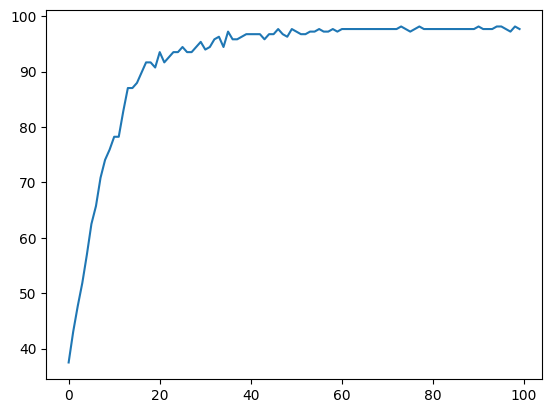

In [ ]:
print("Versão do PyTorch:", torch.__version__)

my_device = get_device()
print_device_info(my_device)

model = model.to(my_device)

epochs = 100
lr = 1e-4
prefix = 'Yolo-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

net = train(train_loader, valid_loader, model, len(train_data),
            epochs=epochs, device=my_device, save=False, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

Sample id: 233
Hit
Predicted: P | Correct: P | Confidence: 84.58%


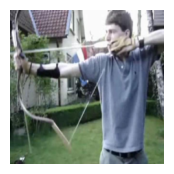

In [65]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    i = np.random.randint(len(test_data))
    sample, true_label = test_data[i]

    plt.figure(figsize=(2,2))
    plt.axis('off')
    img_to_plot = sample.numpy().transpose((1, 2, 0))
    img_to_plot = np.clip(img_to_plot * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    plt.imshow(img_to_plot)

    print(f'Sample id: {i:3d}')

    x = sample.unsqueeze(0).to(my_device)

    output = net(x)
    predictions = torch.softmax(output.squeeze(0), dim=0)

    predicted_class = torch.argmax(predictions).item()
    confidence = predictions[predicted_class].item()

    dataset_classes = train_data.classes

    if predicted_class == true_label:
        print('Hit')
    else:
        print('Miss')

    print(f'Predicted: {dataset_classes[predicted_class]} | '
          f'Correct: {dataset_classes[true_label]} | '
          f'Confidence: {confidence*100:.2f}%')

    # return dataset_classes[y], dataset_classes[data[i][1]], confidence


sample_and_predict(net)
